# Packages

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import bayesflow as bf
import keras

# Explore Data

In [2]:
# Load the data
df=pd.read_csv("fixseqin_PB2expVP10.dat",
     delimiter="\t",
     names=["sentID", "wordID", "duration"],
     usecols=[0, 1, 3])

In [3]:
df.head()

,sentID,wordID,duration
0,1,1,183
1,1,3,165
2,1,3,115
3,1,4,210
4,1,6,266


In [4]:
import pandas as pd

corpus=pd.read_csv("Rcorpus_PB2.dat", delimiter="\t", 
                   #usecols=range(5)
                   )
corpus.head()

,sentID,nw,wordID,length,freq,code
0,1,11,1,3,112.096683,9
1,1,11,2,3,532.671797,9
2,1,11,3,10,3.237331,9
3,1,11,4,4,6557.467940,9
4,1,11,5,3,20527.116504,9


# Define Toyswift

In [5]:
import numpy as np
import pandas as pd


def toyswift_legacy(nu, r, mt=200, eta=-3, NW=10):
    # Processing span normalization constant
    sigma = 1 / (1 + 2 * nu + nu**2)
    
    # Activation
    a = np.zeros(NW)  # Word activation
    
    # Fixation duration Gamma distribution parameters
    shape = 9
    rate = shape / mt  # Gamma density rate
    
    # Initialize variables
    time = 0  # Time
    k = 0  # Fixated word (0-based indexing)
    act = []  # Store word saliencies
    traj = []  # Store trajectory
    
    while True:
        # 1. Generate fixation duration
        tfix = np.random.gamma(shape, 1/rate)
        traj.append([time, k + 1, tfix])  # Store trajectory (1-based indexing for Fixation)
        
        # 2. Update processing rates
        lambda_ = np.zeros(NW)
        if k - 1 >= 0:
            lambda_[k - 1] = nu * sigma
        lambda_[k] = sigma
        if k + 1 < NW:
            lambda_[k + 1] = nu * sigma
        if k + 2 < NW:
            lambda_[k + 2] = nu**2 * sigma
        
        # 3. Evolve activations
        for _ in range(int(tfix)):
            time += 1
            a += r * lambda_ / 1000
            a[a > 1] = 1
            # Compute word saliencies
            s = np.sin(np.pi * a)
            s[a >= 1] = 0
            act.append([time] + s.tolist())
        
        # 4. Check for simulation end condition
        if np.all(a >= 1) or k == NW - 1:
            break
        
        # 5. Compute target selection probabilities
        if np.sum(s) == 0:
            idx = np.where(a == 0)[0]
            if len(idx) > 0:
                s[idx[0]] = 1
            else:
                s[NW - 1] = 1
        s += 10**eta
        p = s / np.sum(s)
        
        # 6. Select saccade target
        k = np.random.choice(NW, p=p)
    
    # Convert results to DataFrame
    #trajectory_df = pd.DataFrame(traj, columns=["Time", "Fixation", "Duration"])
    #activations_df = pd.DataFrame(act, columns=["Time"] + [i+1 for i in range(NW)])
    
    #return {"trajectory": trajectory_df, "activations": activations_df}
    return np.array(traj)


In [2]:
def toyswift(nu, r, mt=200, eta=-3, NW=10, max_saccades=20, skip_ms=10):
    # Processing span normalization constant
    sigma = 1 / (1 + 2 * nu + nu**2)
    
    # Activation
    a = np.zeros(NW)  # Word activation
    
    # Fixation duration Gamma distribution parameters
    shape = 9
    rate = shape / mt  # Gamma density rate
    
    # Initialize variables
    time = 0  # Time
    k = 0  # Fixated word (0-based indexing)
    act = []  # Store word saliencies
    traj = np.zeros((max_saccades,4))  # Store trajectory
    # indexing for storing trajectory values
    i = 0
    while i<max_saccades:
        # 1. Generate fixation duration
        tfix = np.random.gamma(shape, 1/rate)
        traj[i,:] = [time, k + 1, tfix, 1]  # Store trajectory (1-based indexing for Fixation)
        
        # 2. Update processing rates
        lambda_ = np.zeros(NW)
        if k - 1 >= 0:
            lambda_[k - 1] = nu * sigma
        lambda_[k] = sigma
        if k + 1 < NW:
            lambda_[k + 1] = nu * sigma
        if k + 2 < NW:
            lambda_[k + 2] = nu**2 * sigma
        
        # 3. Evolve activations
        for _ in range(0, int(tfix), skip_ms):
            time += skip_ms
            a += r * lambda_ * skip_ms / 1000
            a[a > 1] = 1
            # Compute word saliencies
            s = np.sin(np.pi * a)
            s[a >= 1] = 0
            act.append([time] + s.tolist())
        
        # 4. Check for simulation end condition
        if np.all(a >= 1) or k == NW - 1:
            break
        
        # 5. Compute target selection probabilities
        if np.sum(s) == 0:
            idx = np.where(a == 0)[0]
            if len(idx) > 0:
                s[idx[0]] = 1
            else:
                s[NW - 1] = 1
        s += 10**eta
        p = s / np.sum(s)
        
        # 6. Select saccade target
        k = np.random.choice(NW, p=p)
        i += 1
    return traj

In [4]:
np.array(toyswift(nu = 0.1, r = 10,NW = 10)).shape

(20, 4)

## Plots

In [8]:
sim = toyswift(nu=0.3, r=10, mt=200, eta=-3, NW=10)
nu=0.3; r=10; mt=200 ; eta=-3; NW=10

In [10]:

# Dynamically select all columns that start with "Activation"
df_test = pd.DataFrame(sim["activations"])
activation_columns = df_test.columns[1:]

# Reshape the DataFrame to long format
df_long = df_test.melt(id_vars="Time", value_vars=activation_columns, 
                       var_name="Word", value_name="Value")

fixpos_df = pd.concat([
    pd.DataFrame(sim["trajectory"]),
    pd.DataFrame({
        "Time": [sim["trajectory"]["Time"].iloc[-1] + sim["trajectory"]["Duration"].iloc[-1]],
        "Fixation": [sim["trajectory"]["Fixation"].iloc[-1]],
        "Duration": [np.nan]
    })
])

# Plot trajectory
plt.figure(figsize=(10, 6))
for word in range(1, NW + 1):
    word_data = df_long[df_long["Word"] == word]
    plt.fill_between(
        word_data["Time"],
        word,
        word + 0.9 * word_data["Value"],
        color=sns.color_palette("husl", NW)[word - 1],
        alpha=0.2,
        label=f"Word {word}"
    )

plt.step(
    fixpos_df["Time"],
    fixpos_df["Fixation"],
    where="post",
    color="black",
    linewidth=1,
    label="Fixation"
)


#plt.gca().invert_yaxis()
plt.yticks(range(1, NW + 1), labels=[f"Word {i}" for i in range(1, NW + 1)])
plt.xlabel("Time")
plt.ylabel("Word | Activation>>")
plt.title("Trajectory Plot")
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Build model

## Trial

In [12]:
toyswift(nu, r)

array([[0.00000000e+00, 1.00000000e+00, 1.69066148e+02, 1.00000000e+00],
       [1.70000000e+02, 2.00000000e+00, 8.09233097e+01, 1.00000000e+00],
       [2.50000000e+02, 3.00000000e+00, 3.79719314e+02, 1.00000000e+00],
       [6.30000000e+02, 5.00000000e+00, 1.76954854e+02, 1.00000000e+00],
       [8.10000000e+02, 7.00000000e+00, 1.64404441e+02, 1.00000000e+00],
       [9.80000000e+02, 6.00000000e+00, 1.81154431e+02, 1.00000000e+00],
       [1.17000000e+03, 8.00000000e+00, 2.13921947e+02, 1.00000000e+00],
       [1.39000000e+03, 9.00000000e+00, 2.06600303e+02, 1.00000000e+00],
       [1.60000000e+03, 1.00000000e+01, 1.38948248e+02, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e

In [5]:
def prior():
    # decrease in processing span
    nu=np.random.gamma(shape=8, scale=0.03)
    # individual processing rate
    r=np.random.gamma(shape=18, scale=0.5)
    return dict(nu=nu, r=r)

# generate data for n trials
def likelihood(nu, r, n=10, max_saccades=20):
    trials = np.zeros((n, max_saccades, 4))
    (n,20,4)
    for i in range(n):
        trials[i,:,:] = toyswift(nu, r)
    # return data split by outcome variable ("time of saccade", "gaze fixation", "gaze duration", "real entry")
    return dict(
        time=np.expand_dims(trials[:,:,0], axis=-1), 
        fixation=np.expand_dims(trials[:,:,1], axis=-1), 
        duration=np.expand_dims(trials[:,:,2], axis=-1), 
        real=np.expand_dims(trials[:,:,3], axis=-1)
    )

def context(n=None):
    if n is None:
        n = 20 #np.random.randint(200, 351)
    return dict(n=n)

# sufficient statistics: mean, sd, n
def summary(rt):
    return dict(
        mean = np.mean(rt),
        sd = np.std(rt)
    )

simulator = bf.make_simulator([prior, likelihood]) # exclude context for now

In [6]:
likelihood(2,10)["time"].shape

(10, 20, 1)

In [37]:
df = simulator.sample(1)
df["time"].shape

(1, 250, 20)

In [27]:
df

{'nu': array([[0.3376696]]),
 'r': array([[8.15640481]]),
 'time': array([[[  0., 180., 340., ...,   0.,   0.,   0.],
         [  0., 170., 280., ...,   0.,   0.,   0.],
         [  0., 250., 510., ...,   0.,   0.,   0.],
         ...,
         [  0., 140., 370., ...,   0.,   0.,   0.],
         [  0., 340., 570., ...,   0.,   0.,   0.],
         [  0., 120., 350., ...,   0.,   0.,   0.]]]),
 'fixation': array([[[1., 3., 3., ..., 0., 0., 0.],
         [1., 1., 2., ..., 0., 0., 0.],
         [1., 2., 3., ..., 0., 0., 0.],
         ...,
         [1., 1., 2., ..., 0., 0., 0.],
         [1., 2., 4., ..., 0., 0., 0.],
         [1., 1., 2., ..., 0., 0., 0.]]]),
 'duration': array([[[172.79594006, 158.32011209, 212.04293934, ...,   0.        ,
            0.        ,   0.        ],
         [169.97665904, 109.2143949 , 173.41639364, ...,   0.        ,
            0.        ,   0.        ],
         [244.92968608, 253.87588457, 105.92498531, ...,   0.        ,
            0.        ,   0.     

c:\Users\phili\anaconda3\envs\bayesflow-seminar\Lib\site-packages\seaborn\axisgrid.py:1537: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_k = hue_grouped.get_group(label_k)
c:\Users\phili\anaconda3\envs\bayesflow-seminar\Lib\site-packages\seaborn\axisgrid.py:1537: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_k = hue_grouped.get_group(label_k)
c:\Users\phili\anaconda3\envs\bayesflow-seminar\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


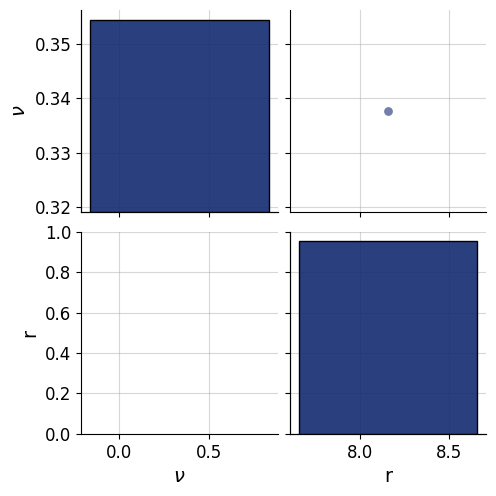

In [28]:
f=bf.diagnostics.pairs_samples(
    df, 
    variable_keys=["nu", "r"],
    variable_names=[r"$\nu$", r"r"])

# Summary Network

In [7]:
adapter = (bf.Adapter()
    #.broadcast("n", to="y")
    #.as_set("y")
    # .constrain("nu", lower=0)
    # .constrain("r", lower=0.5, upper=20)
    # #.rename("n", "inference_conditions")
    #.rename("y", "summary_variables")
    .concatenate(["nu", "r"], into="inference_variables")
    # fixation.shape (batch_size, sentences, max_saccades, 1)
    .concatenate(["time", "fixation", "duration", 'real'], into="summary_variables")
    # summary_variables.shape (batch_size, sentences, max_saccades, 4)
    # .concatenate(['trials'], into='inference_conditions')
    )

In [25]:
class SequentialDeepSet(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.inner = keras.layers.TimeDistributed(
            bf.networks.TimeSeriesNetwork(bidirectional=False, recurrent_dim=64, summary_dim=8) # make layers smaller in case of poor training speed
        )
        self.outer = bf.networks.DeepSet()
    
    def call(self, x, training=False):
        x = self.inner(x, training=training)
        x = self.outer(x, training=training)
        return x
    
summary_network = SequentialDeepSet()

In [42]:
np.random.normal(size=(256, 20, 40, 4)).shape

(256, 20, 40, 4)

In [43]:
summary_network(np.random.normal(size=(256, 20, 40, 4)))

<tf.Tensor: shape=(256, 16), dtype=float32, numpy=
array([[ 0.45825186, -0.5381486 ,  1.50522   , ..., -0.25039962,
        -0.22338898,  0.49653867],
       [ 0.0608073 , -0.43514884,  1.1493652 , ..., -0.2439879 ,
        -0.01124388,  0.20915729],
       [ 0.28587732, -0.71006227,  1.0297581 , ..., -0.20969471,
         0.17489305,  0.17371222],
       ...,
       [ 0.46956736, -0.5349364 ,  1.0511316 , ..., -0.38449994,
        -0.21763188,  0.2649389 ],
       [ 0.32520333, -0.39511964,  1.155948  , ..., -0.27984047,
        -0.09220759,  0.42736164],
       [ 0.10394444, -0.5463209 ,  1.2111788 , ..., -0.17124262,
         0.09598465,  0.30403346]], dtype=float32)>

In [26]:
workflow = bf.BasicWorkflow(
    simulator = simulator,
    adapter = adapter,
    summary_network=summary_network,
    inference_network = bf.networks.CouplingFlow(permutation="swap", subnet_kwargs=dict(dropout=False)),
    inference_variables = ["nu", "r"],
)

In [27]:
train_data = simulator.sample(50)
validation_data = simulator.sample(2)

In [28]:
history=workflow.fit_offline(
    data=train_data, 
    epochs=20, 
    batch_size=25, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 130s 12s/step - loss: 40.0665 - loss/inference_loss: 40.0665 - val_loss: 27.7044 - val_loss/inference_loss: 27.7044
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 26.5706 - loss/inference_loss: 26.5706 - val_loss: 14.2175 - val_loss/inference_loss: 14.2175
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 12.1456 - loss/inference_loss: 12.1456 - val_loss: 4.6729 - val_loss/inference_loss: 4.6729
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 4.0286 - loss/inference_loss: 4.0286 - val_loss: 2.3272 - val_loss/inference_loss: 2.3272
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 2.4619 - loss/inference_loss: 2.4619 - val_loss: 2.5851 - val_loss/inference_loss: 2.5851
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 2.4472 - loss/inference_loss: 2.4472 - val_loss: 2.0364 - val_loss/inference_loss: 2.0364
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 2.0289 - loss/inference_loss: 2.0289 - val_l